Qualitative Gaussian Blob Tests
==

This notebook runs a single gaussian blob test case in several DWAQ-formatted
hydrodynamic datasets, and generates a summary figure for each.

It does not try to adjust the blobs (as in using a coarse representation of the
blob even when using a fine-resolution grid).

The runs are in 3D, but the results are just plotted for the surface layer.


In [159]:
import matplotlib.pyplot as plt
import stompy.plot.cmap as scmap
import xarray as xr
from stompy.grid import unstructured_grid
import numpy as np
import logging as log
from stompy import utils
import os
import six

#%matplotlib notebook
%matplotlib inline

In [35]:
cmap=scmap.load_gradient('turbo.cpt') # a less offensive 'jet'

In [107]:
import stompy.model.delft.waq_scenario as dwaq 

In [49]:
# configure DWAQ:
DELFT_SRC="/home/alliek/software/Delft3D-FM/64634"
DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
DELFT_LIB=os.path.join(DELFT_SRC,"lib")

os.environ['DELFT_SRC']=DELFT_SRC
os.environ['DELFT_SHARE']=DELFT_SHARE
# not great - really should check what's already in there.
os.environ['LD_LIBRARY_PATH']=DELFT_LIB


In [118]:
hydro_agg15k=dwaq.HydroFiles("../agg_wy2013/wy2013c-agg/com-wy2013c-agg.hyd")

In [11]:
hydro_agg15k_lp=dwaq.HydroFiles("../agg_lp_wy2013/com-output.hyd")

In [152]:
hydro_agg6k=dwaq.HydroFiles("/hpcvol1/zhenlin/sfbay/ModelAggregation/dwaq-agg-arc6000_temp/com-wy2013c-agg.hyd")

In [117]:
hydro_agg6k_lp=dwaq.HydroFiles("../agg6k-lp/com-wy2013c-agg6k-lp.hyd")

In [109]:
hydro_orig=dwaq.HydroFiles("/hpcvol1/public/sfb_dfm_v2/wy2013c/DFM_DELWAQ_wy2013c_adj/wy2013c.hyd")

In [114]:
hydro_agg141=dwaq.HydroFiles("../agg141/com-wy2013c-agg141.hyd")

In [120]:
hydro_agg141_lp=dwaq.HydroFiles("../agg141-lp/com-wy2013c-agg141-lp.hyd")

In [163]:
class Blobber(object):
    """
    Wrap the gaussian blob process up into a self-contained class.
    """
    hydro=None
    base_path=None # must be set!

    force=False # whether to allow re-using an existing run
    
    # plume parameters
    X0=np.array([567500,4.16795e6])
    L=5000
    fig_num=None
    zoom=(552164., 595434., 4138443.,4186236.)
    txt_loc=[0.05,0.15] # axes coordinate for location of label
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)   

    def complete(self):
        """
        simulate and plot
        """
        self.run_waq_model()
        self.figure_3panels()
        
    def release_conc_2d(self):
        grid=self.hydro.grid()
        X=grid.cells_centroid()
        
        c=np.exp( -((X-self.X0)**2).sum(axis=-1)/self.L**2 )
        c=c/c.max() # make max value 1
        return c
    def release_conc_3d(self):
        C_2d=self.release_conc_2d()
        C_3d=self.hydro.extrude_element_to_segment(C_2d)
        return C_3d

    def run_waq_model(self):
        assert self.base_path is not None,"Must specify base_path"
        
        if not self.force:
            if os.path.exists(os.path.join(self.base_path,'dwaq_map.nc')):
                log.info("Run seems to exist -- will not run again")
                self.wm=dwaq.WaqModel.load(self.base_path)
                return
            
        # Create a WaqModel, add some tracers, run it.
        self.wm=wm=dwaq.WaqModel(hydro=self.hydro,
                                 overwrite=True,
                                 base_path=self.base_path)
        wm.start_time+= np.timedelta64(5,'D')
        wm.stop_time=wm.start_time + np.timedelta64(5,'D')

        # boundary condition will default to 0.0
        C_3d=self.release_conc_3d()
        wm.substances['dye1']=dwaq.Substance(initial=C_3d)

        # continuity tracer:
        wm.substances['continuity']=dwaq.Substance(initial=1.0)

        # This adds a concentration=1.0 boundary condition on all the boundaries.
        all_bcs=[b.decode() for b in np.unique(hydro.boundary_defs()['type'])]
        wm.add_bc(all_bcs,'continuity',1.0)

        wm.cmd_write_hydro()
        wm.cmd_write_inp()
        wm.cmd_delwaq1()
        wm.cmd_delwaq2()
        wm.write_binary_map_nc()
    def figure_3panels(self):
        ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_map.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig,axs=plt.subplots(1,3,num=self.fig_num)
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)

        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])
        # at the end 
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])

        # continuity
        ax=axs[2]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Continuity",transform=ax.transAxes,va='top')
        coll_cont=grid_ds.plot_cells(values=ds['continuity'].isel(time=-1,layer=0),ax=ax,cmap='seismic',
                                     clim=[0.8,1.2])

        for coll in [coll_ic,coll_ec,coll_cont]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        fig.text(0.5,0.95,self.hydro.hyd_path,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
    

In [164]:
class BlobLSB(Blobber):
    """
    minor adjustment to put a blob in LSB
    """
    X0=np.array([582019,4.14719e6])
    L=5000
    #zoom=(552164., 595434., 4138443.,4186236.)

South Bay Blob
==

The choice of hydro is cryptically hidden in the filename at the top of each figure.

`lp` is lowpass, i.e. with tides removed.

`/hpcvol1/public/...` is the original full resolution hydrodynamics.


INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


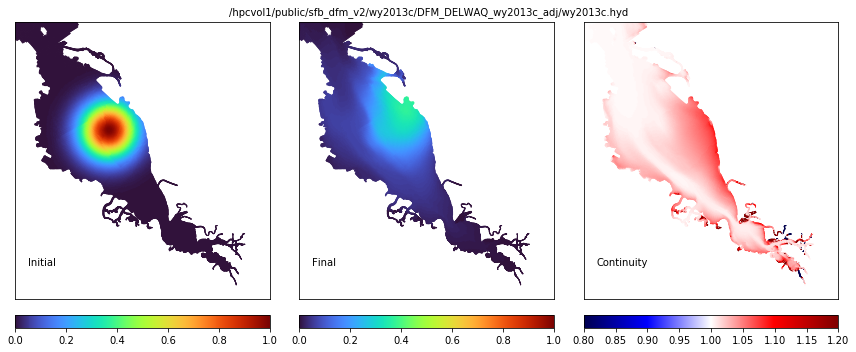

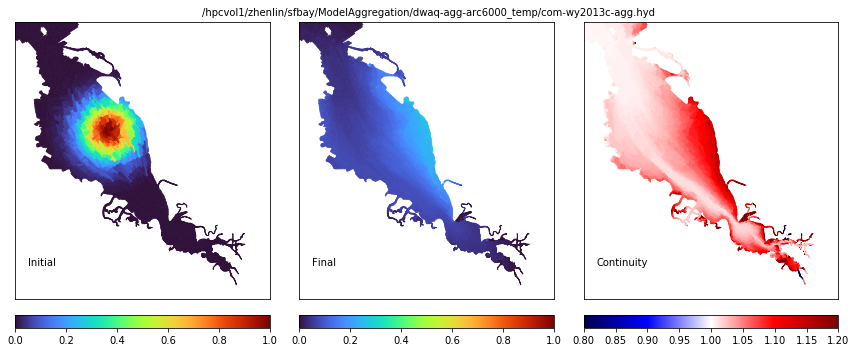

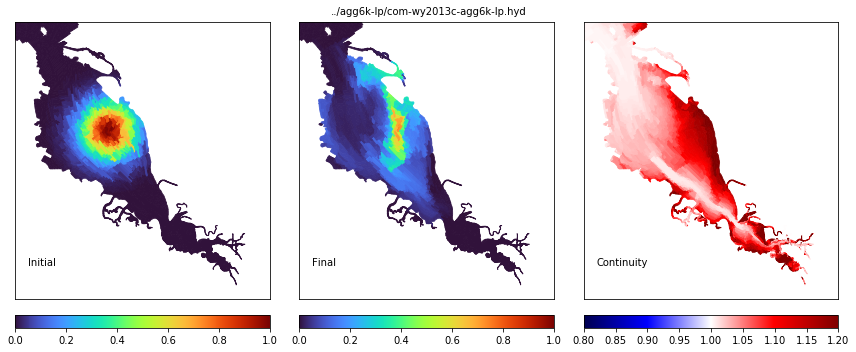

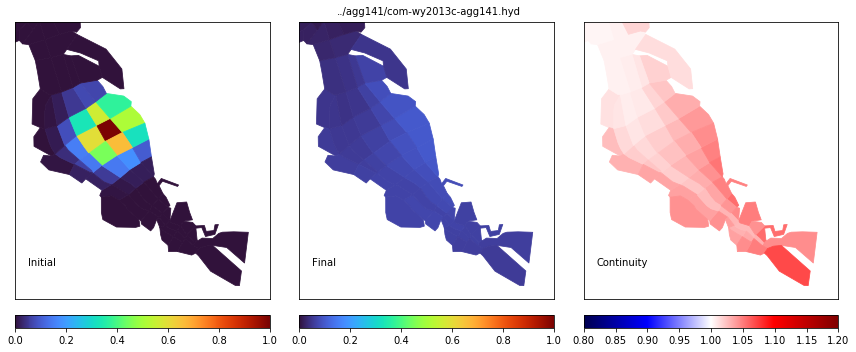

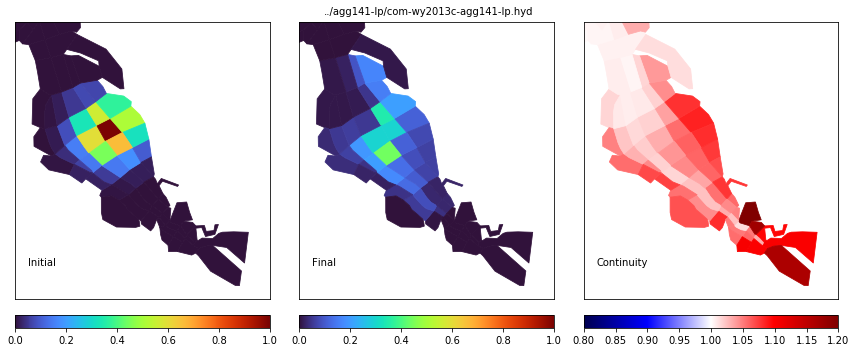

In [165]:
Blobber(base_path='run_orig_gaussian',hydro=hydro_orig).complete()
Blobber(base_path='run_agg6k_gaussian',hydro=hydro_agg6k).complete()
Blobber(base_path='run_agg6k_lp_gaussian',hydro=hydro_agg6k_lp).complete()
Blobber(base_path="run_agg141_gaussian",hydro=hydro_agg141).complete()
Blobber(base_path="run_agg141_lp_gaussian",hydro=hydro_agg141_lp).complete()

Lower South Bay Blob
==

INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


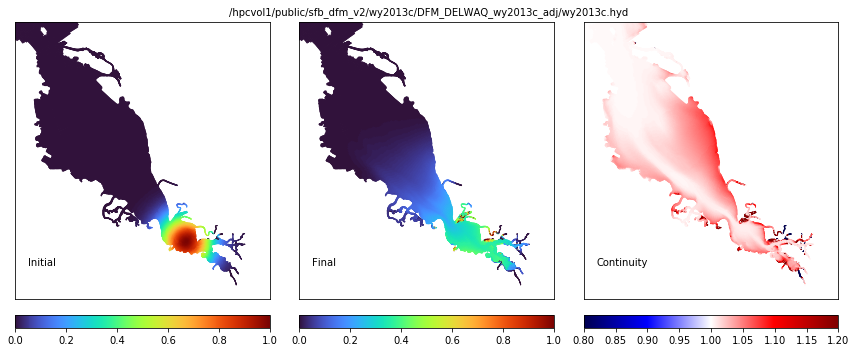

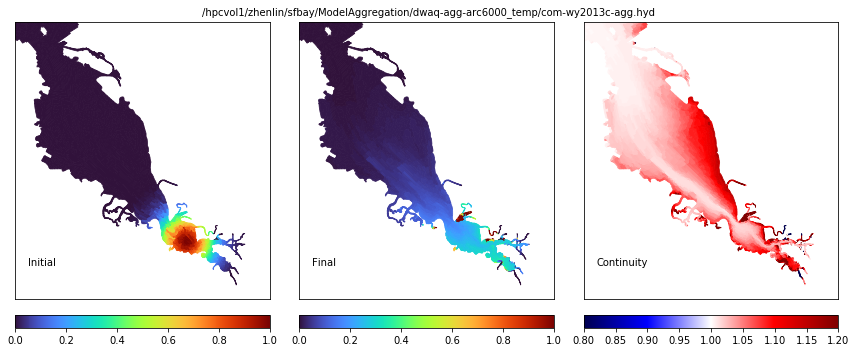

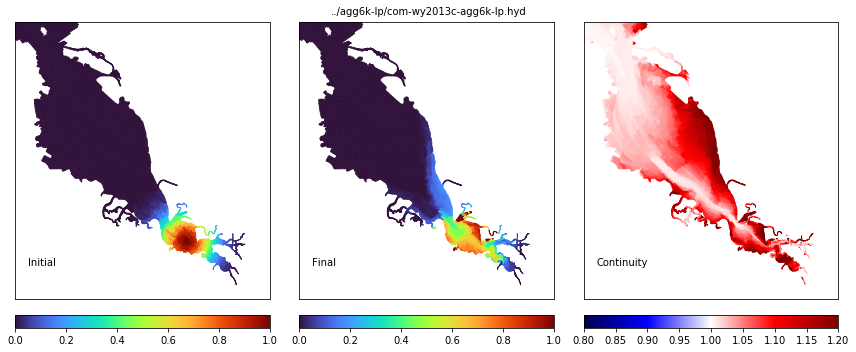

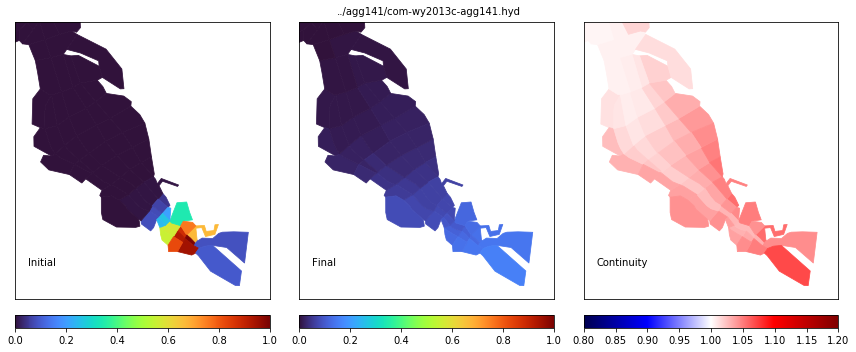

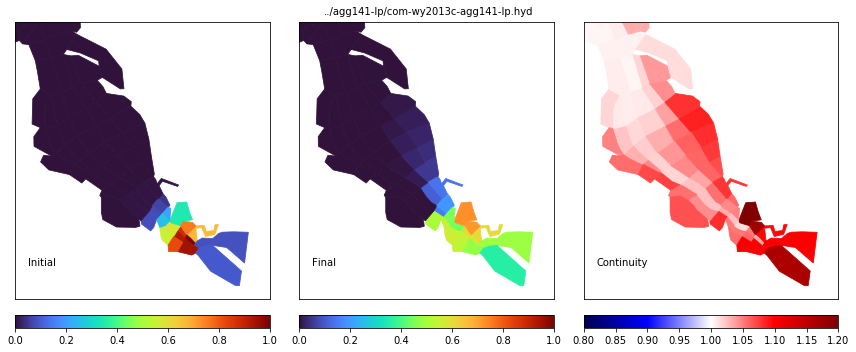

In [166]:
BlobLSB(base_path='run_orig_lsb_gaussian',hydro=hydro_orig).complete()
BlobLSB(base_path='run_agg6k_lsb_gaussian',hydro=hydro_agg6k).complete()
BlobLSB(base_path='run_agg6k_lp_lsb_gaussian',hydro=hydro_agg6k_lp).complete()
BlobLSB(base_path="run_agg141_lsb_gaussian",hydro=hydro_agg141).complete()
BlobLSB(base_path="run_agg141_lp_lsb_gaussian",hydro=hydro_agg141_lp).complete()
